# Simple PINN for an elastic plate with an elliptical hole 

## Geometry

We want to model a quarter of a plate with an elliptical hole. The domain itself is represented by collocation points, the boundaries are represented by uniformly sampled points along the perimeter.

In [76]:
import torch
from torch.optim.lr_scheduler import StepLR, ExponentialLR
import numpy as np
from scipy.stats import qmc
from plotly.express.colors import sequential
import plotly.graph_objects as go
import plotly.figure_factory as ff
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

torch.set_default_dtype(torch.float64)
from global_constants import L, R, MU, LBD, N1, N2

# Elliptical axis in x direction
Rx = 0.14
# Elliptical axis in y direction
Ry = R**2 / Rx
# Number of points for one boundary 
N = 25
# Number of collocation points
collo_number = 500

# Number of hidden neurons
hn = 50 #previous value hn->50

# Weight of PDE loss
# W_PDE = 0.00001 #previous value -> 0.001
# # Weight of Neumann loss
# W_NEU = 0.0005 #previous value -> 0.05 
# # Weight of data losses
# W_STRESS = 0.0
# W_DISP = 0.0


# Load reference data
data_input = torch.as_tensor(
    np.loadtxt(f"data/inputs_Rx={Rx}.csv", delimiter=","), dtype=torch.float64
)
data_output = torch.as_tensor(
    np.loadtxt(f"data/outputs_Rx={Rx}.csv", delimiter=","), dtype=torch.float64
)

# Create collocation points
points = L * qmc.LatinHypercube(d=2).random(N**4)
mask = (((points[:, 0] ** 2) / (Rx**2)) + ((points[:, 1] ** 2) / (Ry**2))) > 1
valid_points = points[mask]
density = 1 / (valid_points[:,0]**2 / Rx**2 + valid_points[:,1]**2 / Ry**2)
selected_points = np.random.choice(len(valid_points[:,0]), size= collo_number, replace= False,  p = density / np.sum(density))
collocation = torch.tensor(valid_points[selected_points], requires_grad=True).double()

# Boundary points
x_top = torch.linspace(0, L, N, requires_grad=True).double()
y_top = L * torch.ones((N, 1), requires_grad=True).double()
top = torch.column_stack([x_top, y_top]).double()

NN = int(N * (L - Rx) / L)
x_bottom = torch.linspace(Rx, L, NN).double()
y_bottom = torch.zeros((NN, 1)).double()
bottom = torch.column_stack([x_bottom, y_bottom]).double()

NN = int(N * (L - Ry) / L)
x_left = torch.zeros((NN, 1)).double()
y_left = torch.linspace(Ry, L, NN).double()
left = torch.column_stack([x_left, y_left]).double()

x_right = L * torch.ones((N, 1)).double()
y_right = torch.linspace(0, L, N).double()
right = torch.column_stack([x_right, y_right]).double()

phi = np.linspace(0, 0.5 * np.pi, int(5*N * np.pi * Rx / L))
x_hole = torch.tensor(Rx * np.cos(phi), requires_grad=True).double()
y_hole = torch.tensor(Ry * np.sin(phi), requires_grad=True).double()
n_hole = torch.tensor(np.stack([-Ry * np.cos(phi), -Rx * np.sin(phi)]).T).double()
n_hole = n_hole / torch.linalg.norm(n_hole, axis=1)[:, None]
hole = torch.column_stack([x_hole, y_hole]).double()

# Visualize geometry
with torch.no_grad():
    mode = "markers"
    gray = dict(color="#C9C5BC")
    green = dict(color="#006561")
    black = dict(color="black")
    fig = ff.create_quiver(hole[:, 0], hole[:, 1], n_hole[:, 0], n_hole[:, 1], marker=black)
    fig.add_trace(go.Scatter(x=collocation[:, 0], y=collocation[:, 1], mode=mode, marker=gray))
    fig.add_trace(go.Scatter(x=top[:, 0], y=top[:, 1], mode=mode, marker=green))
    fig.add_trace(go.Scatter(x=bottom[:, 0], y=bottom[:, 1], mode=mode, marker=green))
    fig.add_trace(go.Scatter(x=left[:, 0], y=left[:, 1], mode=mode, marker=green))
    fig.add_trace(go.Scatter(x=right[:, 0], y=right[:, 1], mode=mode, marker=green))
    fig.add_trace(go.Scatter(x=hole[:, 0], y=hole[:, 1], mode=mode, marker=black))
    fig.layout.yaxis.scaleanchor = "x"
    fig.update_layout(
        template="none",
        width=400,
        height=400,
        margin=dict(l=0, r=0, b=0, t=0),
        showlegend=False,
    )
    fig.update_xaxes(visible=False)
    fig.update_yaxes(visible=False)
    fig.show()

## The ANN model that approximates the displacement field

An ANN might be considered as a generic function approximator. In this case, it should approximated the function $u: \mathcal{R}^2 \rightarrow \mathcal{R}^2$ with five hidden layers having 20 neurons each.

In [77]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer1 = torch.nn.Linear(2, hn)
        self.hidden_layer2 = torch.nn.Linear(hn, hn)
        self.hidden_layer3 = torch.nn.Linear(hn, hn)
        self.hidden_layer4 = torch.nn.Linear(hn, hn)
        self.hidden_layer5 = torch.nn.Linear(hn, hn)
        self.output_layer = torch.nn.Linear(hn, 2)

    def forward(self, inputs):
        layer1_out = torch.tanh(self.hidden_layer1(inputs))
        layer2_out = torch.tanh(self.hidden_layer2(layer1_out))
        layer3_out = torch.tanh(self.hidden_layer3(layer2_out))
        layer4_out = torch.tanh(self.hidden_layer4(layer3_out))
        layer5_out = torch.tanh(self.hidden_layer5(layer4_out))
        output = self.output_layer(layer5_out)
        return output

#reset all network parameters    
def weight_reset(m):
    reset_parameters = getattr(m, "reset_parameters", None)
    if callable(reset_parameters):
        m.reset_parameters()

net = Net()

## The physics

We want to solve linear elasticity on the domain, which means ultimately that we want to minimize the residual of the following PDE 
$$\frac{\partial \sigma_{11}}{\partial x_1} + \frac{\partial \sigma_{12}}{\partial x_2} - b_1 = 0$$
$$\frac{\partial \sigma_{21}}{\partial x_1} + \frac{\partial \sigma_{22}}{\partial x_2} - b_2 = 0$$
with stress 
$$ \sigma_{ij} = 2\mu \varepsilon_{ij} + \lambda \varepsilon_{kk} \delta_{ij} $$
and strain 
$$ \varepsilon_{ij} = \frac{1}{2} \left( \frac{\partial u_i}{\partial x_j} +  \frac{\partial u_j}{\partial x_i}\right).$$

In [78]:
def epsilon(x):
    # Compute deformation gradient
    dudx = torch.func.jacrev(net)(x)
    return 0.5 * (dudx + dudx.T)

def sigma(x):
    # Compute (small deformation) strain
    eps = epsilon(x)
    # Compute linear elastic strain (assuming plane stress)
    return 2.0 * MU * eps + (2*LBD*MU)/(2*MU+LBD) * torch.trace(eps) * torch.eye(2)


def pde_residual(x):
    # Compute stress gradient
    dsdx = torch.func.jacrev(sigma)(x)
    # Momentum balance in x direction
    residual_x = dsdx[0, 0, 0] + dsdx[0, 1, 1] 
    # Momentum balance in y direction
    residual_y = dsdx[1, 0, 0] + dsdx[1, 1, 1]
    return residual_x, residual_y

## Boundary conditions

Left: 

$$ u_1 = 0$$

Bottom: 

$$ u_2 = 0$$

Top: 

$$ \sigma \cdot n = N_2 n$$

Right: 

$$ \sigma \cdot n = N_1 n$$

In [79]:
mse = torch.nn.MSELoss()


def compute_physics_losses(complete_collo):
    # pde
    res_x, res_y = torch.vmap(pde_residual)(complete_collo)
    zeros = torch.zeros_like(res_x)
    pde_error = mse((res_x), zeros) + mse((res_y), zeros)

    # left boundary
    pred_left = net(left)
    bc_left = torch.zeros_like(pred_left[:, 0])
    left_error = mse(pred_left[:, 0], bc_left)

    # bottom boundary
    pred_bottom = net(bottom)
    bc_bottom = torch.zeros_like(pred_bottom[:, 1])
    bottom_error = mse(pred_bottom[:, 1], bc_bottom)

    # top boundary
    pred_stress_top = torch.vmap(sigma)(top)
    pred_s_top_yy = pred_stress_top[:,1,1]
    pred_s_top_xy = pred_stress_top[:,0,1]
    s_top_yy = N2*torch.ones_like(pred_s_top_yy)
    s_top_xy = torch.zeros_like(pred_s_top_xy)
    top_error = mse(pred_s_top_yy, s_top_yy) + mse(pred_s_top_xy, s_top_xy)

    # right boundary
    pred_stress_right = torch.vmap(sigma)(right)
    pred_s_right_xx = pred_stress_right[:,0,0]
    pred_s_right_xy = pred_stress_right[:,1,0]
    s_right_xx = N1*torch.ones_like(pred_s_right_xx)
    s_right_xy = torch.zeros_like(pred_s_right_xy)
    right_error = mse(pred_s_right_xx, s_right_xx) + mse(pred_s_right_xy, s_right_xy)


    # hole boundary
    stress_hole = torch.vmap(sigma)(hole)
    traction = torch.einsum("...ij,...j->...i", stress_hole, n_hole)
    zeros = torch.zeros_like(traction[:, 0])
    hole_error = mse(traction[:, 0], zeros) + mse(traction[:, 1], zeros)


    return (left_error, right_error, bottom_error, top_error, hole_error, pde_error)

## Training 

  0%|          | 0/4000 [00:00<?, ?it/s]

100%|█████████▉| 3999/4000 [15:47<00:00,  4.08it/s]

ADAM Weight_NEU: 1.8841683879627231e-06, ADAM Weight_PDE: 3.1355081392423563e-06


100%|██████████| 4000/4000 [15:47<00:00,  4.22it/s]


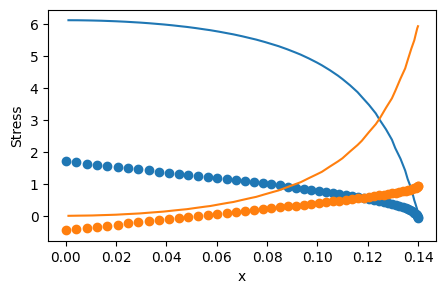

iteration: 1, Weight_NEU: 1.7841683879627487e-06, Weight_PDE: 3.035508139242486e-06, Stress Error: 20.360257875738064, , lr: 9.999999e-08


100%|█████████▉| 3999/4000 [16:31<00:00,  4.03it/s]

ADAM Weight_NEU: 1.7841683879627487e-06, ADAM Weight_PDE: 3.035508139242486e-06


100%|██████████| 4000/4000 [16:31<00:00,  4.03it/s]


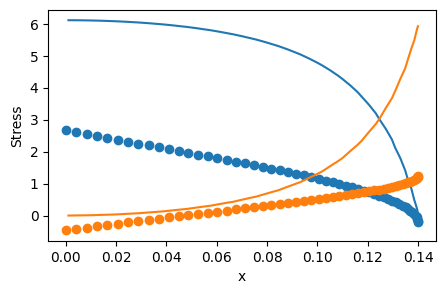

iteration: 2, Weight_NEU: 1.6973752557891162e-06, Weight_PDE: 2.936172794774429e-06, Stress Error: 16.60974381022758, , lr: 9.999998000000101e-08


100%|█████████▉| 3999/4000 [16:30<00:00,  4.04it/s]

ADAM Weight_NEU: 1.6973752557891162e-06, ADAM Weight_PDE: 2.936172794774429e-06


100%|██████████| 4000/4000 [16:30<00:00,  4.04it/s]


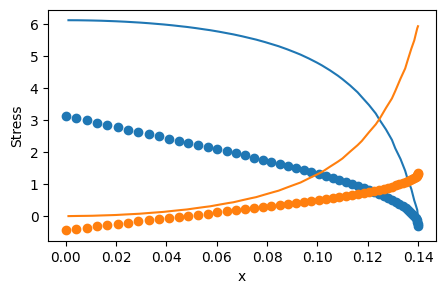

iteration: 3, Weight_NEU: 1.6188577684975933e-06, Weight_PDE: 2.8413641105031766e-06, Stress Error: 15.107560949258463, , lr: 9.999997000000301e-08


100%|█████████▉| 3999/4000 [16:31<00:00,  4.03it/s]

ADAM Weight_NEU: 1.6188577684975933e-06, ADAM Weight_PDE: 2.8413641105031766e-06


100%|██████████| 4000/4000 [16:32<00:00,  4.03it/s]


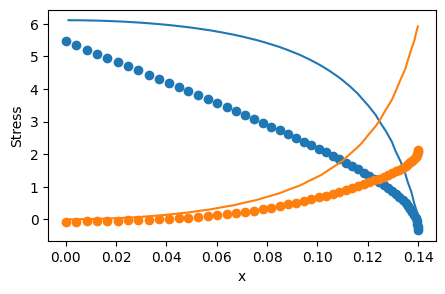

iteration: 4, Weight_NEU: 1.547422111563173e-06, Weight_PDE: 2.7495416352744777e-06, Stress Error: 8.606910589183707, , lr: 9.999996000000602e-08


100%|█████████▉| 3999/4000 [16:27<00:00,  4.10it/s]

ADAM Weight_NEU: 1.547422111563173e-06, ADAM Weight_PDE: 2.7495416352744777e-06


100%|██████████| 4000/4000 [16:27<00:00,  4.05it/s]


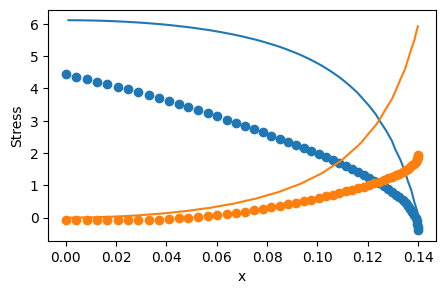

iteration: 5, Weight_NEU: 1.4762954684201502e-06, Weight_PDE: 2.6565855638625116e-06, Stress Error: 10.182218338166582, , lr: 9.999995000001002e-08


100%|█████████▉| 3999/4000 [16:29<00:00,  4.08it/s]

ADAM Weight_NEU: 1.4762954684201502e-06, ADAM Weight_PDE: 2.6565855638625116e-06


100%|██████████| 4000/4000 [16:29<00:00,  4.04it/s]


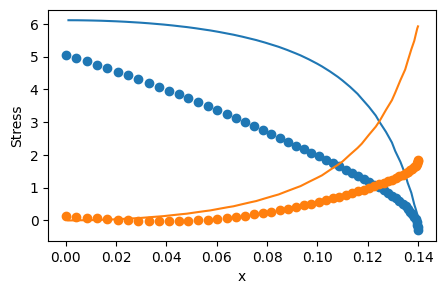

iteration: 6, Weight_NEU: 1.4099448357360436e-06, Weight_PDE: 2.564326651211388e-06, Stress Error: 9.696918838047825, , lr: 9.999994000001502e-08


100%|█████████▉| 3999/4000 [16:29<00:00,  4.06it/s]

ADAM Weight_NEU: 1.4099448357360436e-06, ADAM Weight_PDE: 2.564326651211388e-06


100%|██████████| 4000/4000 [16:29<00:00,  4.04it/s]


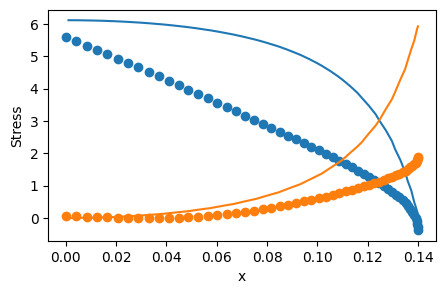

iteration: 7, Weight_NEU: 1.3435664779160905e-06, Weight_PDE: 2.4706887073083807e-06, Stress Error: 8.965817131973145, , lr: 9.999993000002102e-08


100%|█████████▉| 3999/4000 [16:29<00:00,  4.08it/s]

ADAM Weight_NEU: 1.3435664779160905e-06, ADAM Weight_PDE: 2.4706887073083807e-06


100%|██████████| 4000/4000 [16:30<00:00,  4.04it/s]


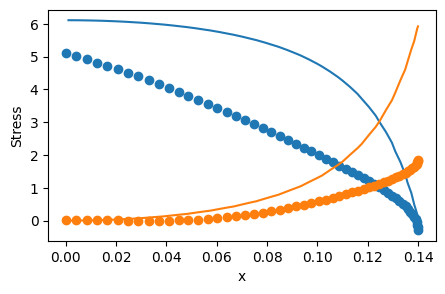

iteration: 8, Weight_NEU: 1.2793228291756468e-06, Weight_PDE: 2.375734143512099e-06, Stress Error: 9.46742210426116, , lr: 9.999992000002803e-08


100%|█████████▉| 3999/4000 [16:27<00:00,  4.07it/s]

ADAM Weight_NEU: 1.2793228291756468e-06, ADAM Weight_PDE: 2.375734143512099e-06


100%|██████████| 4000/4000 [16:28<00:00,  4.05it/s]


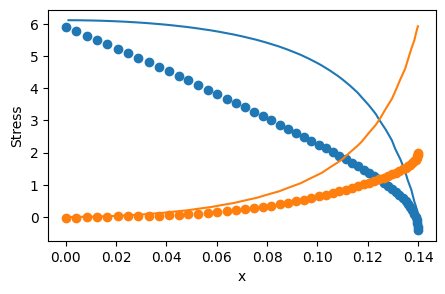

iteration: 9, Weight_NEU: 1.2141422727797927e-06, Weight_PDE: 2.2815153720777224e-06, Stress Error: 8.197345850371383, , lr: 9.999991000003604e-08


100%|█████████▉| 3999/4000 [16:20<00:00,  4.08it/s]

ADAM Weight_NEU: 1.2141422727797927e-06, ADAM Weight_PDE: 2.2815153720777224e-06


100%|██████████| 4000/4000 [16:21<00:00,  4.08it/s]


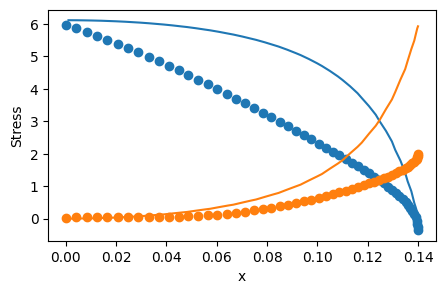

iteration: 10, Weight_NEU: 1.1517493918476835e-06, Weight_PDE: 2.189398458511852e-06, Stress Error: 7.856110061535828, , lr: 9.999990000004504e-08


100%|█████████▉| 3999/4000 [16:21<00:00,  4.11it/s]

ADAM Weight_NEU: 1.1517493918476835e-06, ADAM Weight_PDE: 2.189398458511852e-06


100%|██████████| 4000/4000 [16:21<00:00,  4.07it/s]


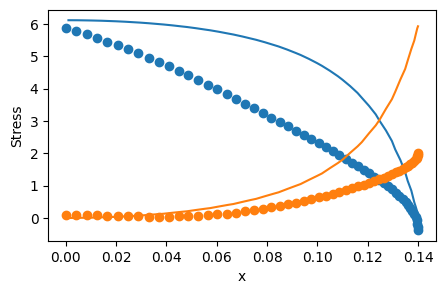

iteration: 11, Weight_NEU: 1.0900859267003416e-06, Weight_PDE: 2.098318138881643e-06, Stress Error: 7.912658021752299, , lr: 9.999989000005505e-08


100%|█████████▉| 3999/4000 [16:24<00:00,  4.11it/s]

ADAM Weight_NEU: 1.0900859267003416e-06, ADAM Weight_PDE: 2.098318138881643e-06


100%|██████████| 4000/4000 [16:24<00:00,  4.06it/s]


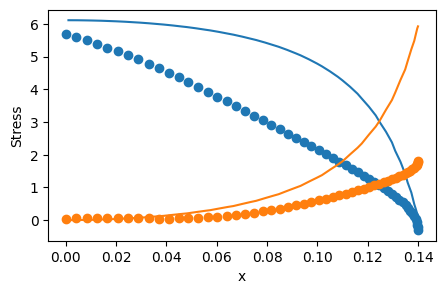

iteration: 12, Weight_NEU: 1.0318471546526209e-06, Weight_PDE: 2.009823980445808e-06, Stress Error: 8.665985084438985, , lr: 9.999988000006605e-08


100%|█████████▉| 3999/4000 [16:24<00:00,  4.08it/s]

ADAM Weight_NEU: 1.0318471546526209e-06, ADAM Weight_PDE: 2.009823980445808e-06


100%|██████████| 4000/4000 [16:24<00:00,  4.06it/s]


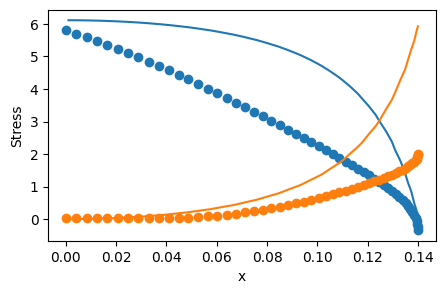

iteration: 13, Weight_NEU: 9.735482650798891e-07, Weight_PDE: 1.918642963462116e-06, Stress Error: 8.159523095830226, , lr: 9.999987000007806e-08


100%|█████████▉| 3999/4000 [16:21<00:00,  4.09it/s]

ADAM Weight_NEU: 9.735482650798891e-07, ADAM Weight_PDE: 1.918642963462116e-06


100%|██████████| 4000/4000 [16:21<00:00,  4.07it/s]


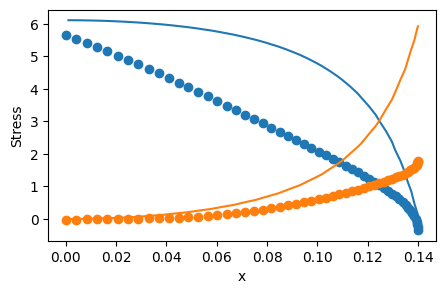

iteration: 14, Weight_NEU: 9.150907279940427e-07, Weight_PDE: 1.8260309857993725e-06, Stress Error: 9.006474343957791, , lr: 9.999986000009106e-08


100%|█████████▉| 3999/4000 [16:24<00:00,  4.09it/s]

ADAM Weight_NEU: 9.150907279940427e-07, ADAM Weight_PDE: 1.8260309857993725e-06


100%|██████████| 4000/4000 [16:24<00:00,  4.06it/s]


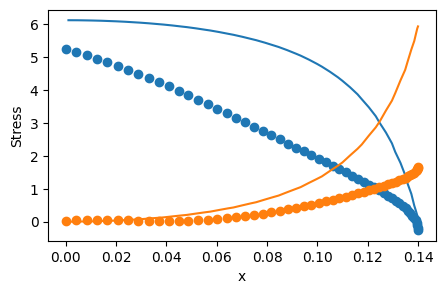

iteration: 15, Weight_NEU: 8.578905731681834e-07, Weight_PDE: 1.7353583872593571e-06, Stress Error: 9.815621819905703, , lr: 9.999985000010507e-08


100%|█████████▉| 3999/4000 [16:54<00:00,  2.80it/s]

ADAM Weight_NEU: 8.578905731681834e-07, ADAM Weight_PDE: 1.7353583872593571e-06


100%|██████████| 4000/4000 [16:54<00:00,  3.94it/s]


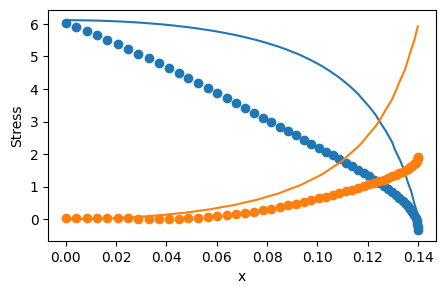

iteration: 16, Weight_NEU: 8.000527844490267e-07, Weight_PDE: 1.6455932334397584e-06, Stress Error: 8.281936656771798, , lr: 9.999984000012008e-08


100%|█████████▉| 3999/4000 [18:28<00:00,  3.66it/s]

ADAM Weight_NEU: 8.000527844490267e-07, ADAM Weight_PDE: 1.6455932334397584e-06


100%|██████████| 4000/4000 [18:28<00:00,  3.61it/s]


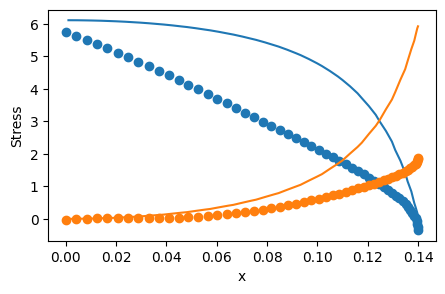

iteration: 17, Weight_NEU: 7.393099973991819e-07, Weight_PDE: 1.5538114925396922e-06, Stress Error: 8.740058479490862, , lr: 9.999983000013608e-08


100%|█████████▉| 3999/4000 [17:14<00:00,  4.16it/s]

ADAM Weight_NEU: 7.393099973991819e-07, ADAM Weight_PDE: 1.5538114925396922e-06


100%|██████████| 4000/4000 [17:14<00:00,  3.87it/s]


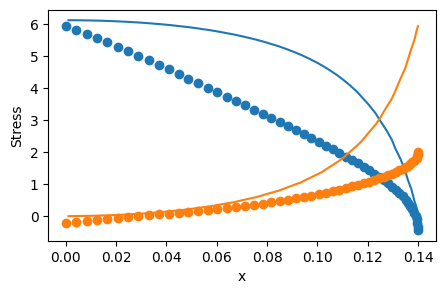

iteration: 18, Weight_NEU: 6.689103529845687e-07, Weight_PDE: 1.4572836687077941e-06, Stress Error: 7.973300329154246, , lr: 9.999982000015309e-08


100%|█████████▉| 3999/4000 [27:21<00:00,  1.40it/s]  

ADAM Weight_NEU: 6.689103529845687e-07, ADAM Weight_PDE: 1.4572836687077941e-06


100%|██████████| 4000/4000 [27:22<00:00,  2.44it/s]


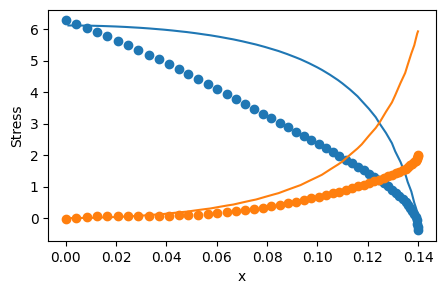

iteration: 19, Weight_NEU: 5.948637120236002e-07, Weight_PDE: 1.3599121679599436e-06, Stress Error: 7.658459274506258, , lr: 9.99998100001711e-08


100%|█████████▉| 3999/4000 [36:36<00:00,  1.65it/s]

ADAM Weight_NEU: 5.948637120236002e-07, ADAM Weight_PDE: 1.3599121679599436e-06


100%|██████████| 4000/4000 [36:36<00:00,  1.82it/s]


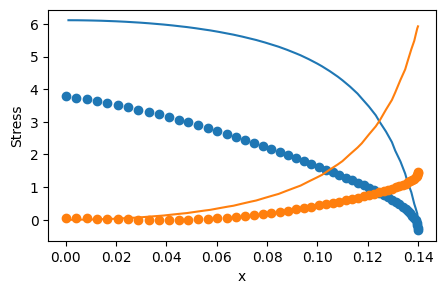

iteration: 20, Weight_NEU: 5.210146301655014e-07, Weight_PDE: 1.2650679469165555e-06, Stress Error: 12.499618201474588, , lr: 9.99998000001901e-08


100%|█████████▉| 3999/4000 [39:28<00:00,  1.68it/s]  

ADAM Weight_NEU: 5.210146301655014e-07, ADAM Weight_PDE: 1.2650679469165555e-06


100%|██████████| 4000/4000 [39:29<00:00,  1.69it/s]


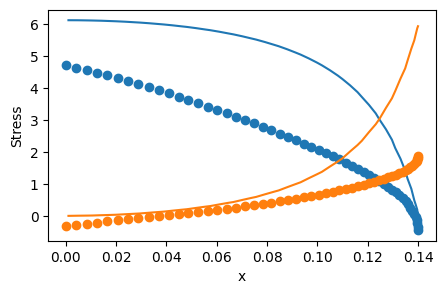

iteration: 21, Weight_NEU: 4.380356946324343e-07, Weight_PDE: 1.1692303728421577e-06, Stress Error: 9.665547681825336, , lr: 9.99997900002101e-08


100%|█████████▉| 3999/4000 [45:56<00:00,  1.74it/s]  

ADAM Weight_NEU: 4.380356946324343e-07, ADAM Weight_PDE: 1.1692303728421577e-06


100%|██████████| 4000/4000 [45:57<00:00,  1.45it/s]


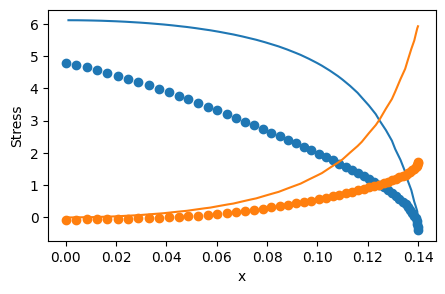

iteration: 22, Weight_NEU: 3.566018960563357e-07, Weight_PDE: 1.0762424413911544e-06, Stress Error: 9.949669787658468, , lr: 9.999978000023111e-08


100%|█████████▉| 3999/4000 [36:52<00:00,  2.20it/s]

ADAM Weight_NEU: 3.566018960563357e-07, ADAM Weight_PDE: 1.0762424413911544e-06


100%|██████████| 4000/4000 [36:53<00:00,  1.81it/s]


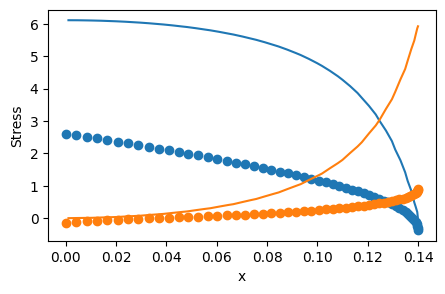

iteration: 23, Weight_NEU: 2.711458246158152e-07, Weight_PDE: 9.813754933790138e-07, Stress Error: 17.18401435200251, , lr: 9.999977000025311e-08


100%|█████████▉| 3999/4000 [32:42<00:00,  2.20it/s]

ADAM Weight_NEU: 2.711458246158152e-07, ADAM Weight_PDE: 9.813754933790138e-07


100%|██████████| 4000/4000 [32:42<00:00,  2.04it/s]


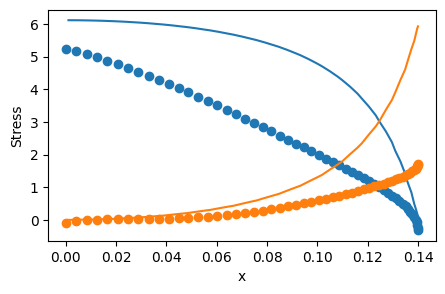

iteration: 24, Weight_NEU: 1.892688211091894e-07, Weight_PDE: 8.903188517314126e-07, Stress Error: 9.498714080288723, , lr: 9.999976000027612e-08


100%|█████████▉| 3999/4000 [33:26<00:00,  1.82it/s]

ADAM Weight_NEU: 1.892688211091894e-07, ADAM Weight_PDE: 8.903188517314126e-07


100%|██████████| 4000/4000 [33:27<00:00,  1.99it/s]


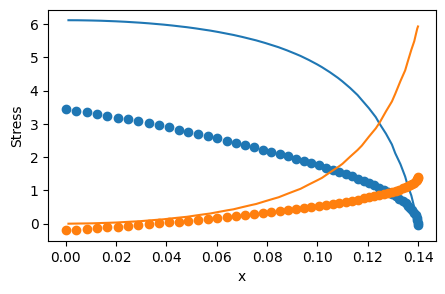

iteration: 25, Weight_NEU: 1.0987120402575567e-07, Weight_PDE: 7.940731399342346e-07, Stress Error: 12.236933088911222, , lr: 9.999975000030013e-08


100%|█████████▉| 3999/4000 [33:27<00:00,  1.80it/s]

ADAM Weight_NEU: 1.0987120402575567e-07, ADAM Weight_PDE: 7.940731399342346e-07


100%|██████████| 4000/4000 [33:27<00:00,  1.99it/s]


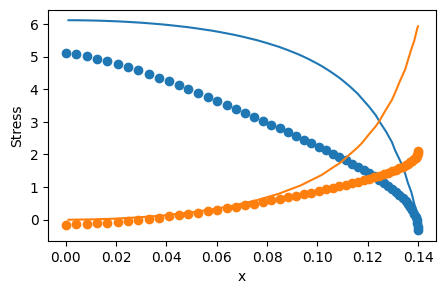

iteration: 26, Weight_NEU: 2.3831891060120797e-08, Weight_PDE: 7.017643659043741e-07, Stress Error: 8.35037033959321, , lr: 9.999974000032513e-08


100%|█████████▉| 3999/4000 [33:19<00:00,  1.74it/s]

ADAM Weight_NEU: 2.3831891060120797e-08, ADAM Weight_PDE: 7.017643659043741e-07


100%|██████████| 4000/4000 [33:19<00:00,  2.00it/s]


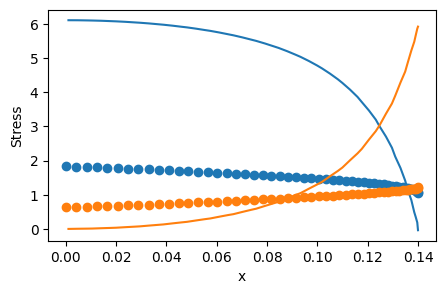

iteration: 27, Weight_NEU: -6.956424381527895e-08, Weight_PDE: 6.125969012237443e-07, Stress Error: 15.56767143786875, , lr: 9.999973000035114e-08


100%|█████████▉| 3999/4000 [31:42<00:00,  2.25it/s]  

ADAM Weight_NEU: 6.956424381527895e-08, ADAM Weight_PDE: 6.125969012237443e-07


100%|██████████| 4000/4000 [31:43<00:00,  2.10it/s]


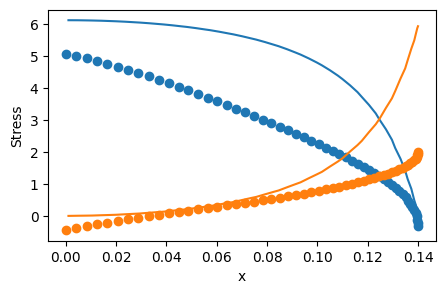

iteration: 28, Weight_NEU: -1.4347185531291065e-07, Weight_PDE: 5.273039873008007e-07, Stress Error: 8.52766897813356, , lr: 9.999972000037815e-08


100%|█████████▉| 3999/4000 [33:05<00:00,  1.69it/s]

ADAM Weight_NEU: 1.4347185531291065e-07, ADAM Weight_PDE: 5.273039873008007e-07


100%|██████████| 4000/4000 [33:05<00:00,  2.01it/s]


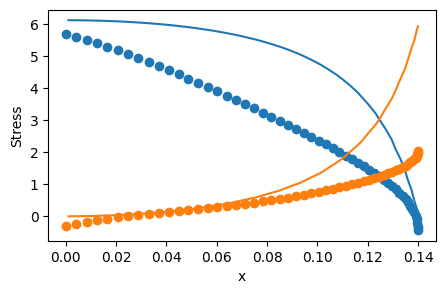

iteration: 29, Weight_NEU: -2.0397542253114664e-07, Weight_PDE: 4.3736067044520363e-07, Stress Error: 7.849751606132532, , lr: 9.999971000040615e-08


100%|█████████▉| 3999/4000 [34:41<00:00,  1.82it/s] 

ADAM Weight_NEU: 2.0397542253114664e-07, ADAM Weight_PDE: 4.3736067044520363e-07


100%|██████████| 4000/4000 [34:42<00:00,  1.92it/s]


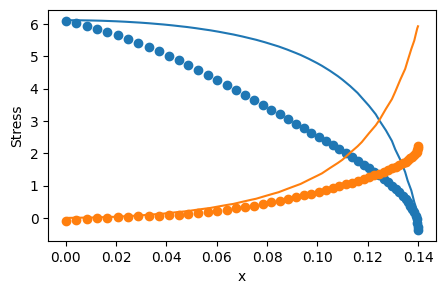

iteration: 30, Weight_NEU: -2.562680225071494e-07, Weight_PDE: 3.431867684027948e-07, Stress Error: 7.008247903689072, , lr: 9.999970000043516e-08


100%|█████████▉| 3999/4000 [33:17<00:00,  2.21it/s]

ADAM Weight_NEU: 2.562680225071494e-07, ADAM Weight_PDE: 3.431867684027948e-07


100%|██████████| 4000/4000 [33:18<00:00,  2.00it/s]


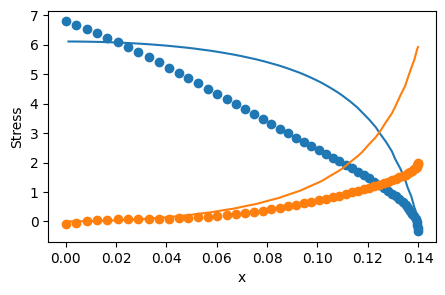

iteration: 31, Weight_NEU: -3.0165739626450133e-07, Weight_PDE: 2.434797614733814e-07, Stress Error: 7.256576512431158, , lr: 9.999969000046516e-08


100%|█████████▉| 3999/4000 [33:49<00:00,  1.80it/s]

ADAM Weight_NEU: 3.0165739626450133e-07, ADAM Weight_PDE: 2.434797614733814e-07


100%|██████████| 4000/4000 [33:49<00:00,  1.97it/s]


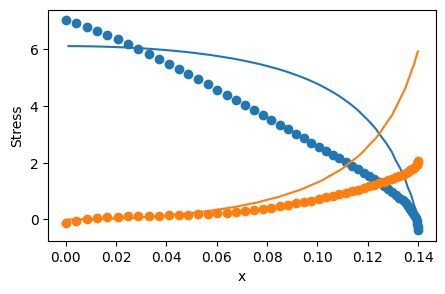

iteration: 32, Weight_NEU: -3.4184886003447276e-07, Weight_PDE: 1.385044869993947e-07, Stress Error: 6.826346841984709, , lr: 9.999968000049616e-08


100%|█████████▉| 3999/4000 [33:43<00:00,  1.72it/s]

ADAM Weight_NEU: 3.4184886003447276e-07, ADAM Weight_PDE: 1.385044869993947e-07


100%|██████████| 4000/4000 [33:43<00:00,  1.98it/s]


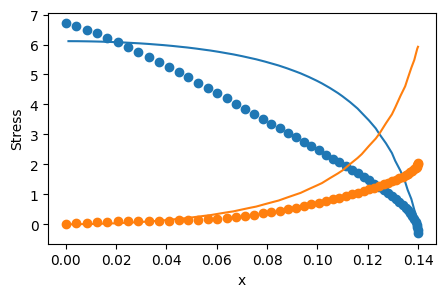

iteration: 33, Weight_NEU: -3.764532312618845e-07, Weight_PDE: 3.3913529601433594e-08, Stress Error: 7.106605299175049, , lr: 9.999967000052817e-08


100%|█████████▉| 3999/4000 [33:19<00:00,  2.22it/s]

ADAM Weight_NEU: 3.764532312618845e-07, ADAM Weight_PDE: 3.3913529601433594e-08


100%|██████████| 4000/4000 [33:20<00:00,  2.00it/s]


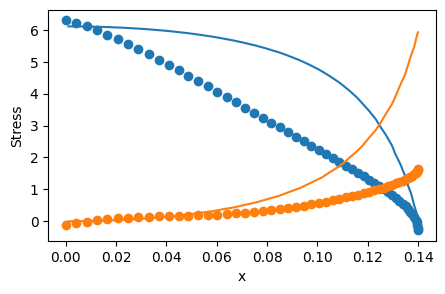

iteration: 34, Weight_NEU: -4.073041246967038e-07, Weight_PDE: -7.372779650606972e-08, Stress Error: 8.227781671405387, , lr: 9.999966000056118e-08


100%|█████████▉| 3999/4000 [33:29<00:00,  1.82it/s]

ADAM Weight_NEU: 4.073041246967038e-07, ADAM Weight_PDE: 7.372779650606972e-08


100%|██████████| 4000/4000 [33:30<00:00,  1.99it/s]


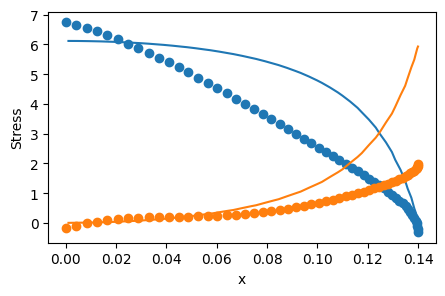

iteration: 35, Weight_NEU: -4.3493228964067485e-07, Weight_PDE: -1.512496918267585e-07, Stress Error: 6.987228097413072, , lr: 9.999965000059518e-08


100%|█████████▉| 3999/4000 [33:43<00:01,  1.02s/it]

ADAM Weight_NEU: 4.3493228964067485e-07, ADAM Weight_PDE: 1.512496918267585e-07


100%|██████████| 4000/4000 [33:44<00:00,  1.98it/s]


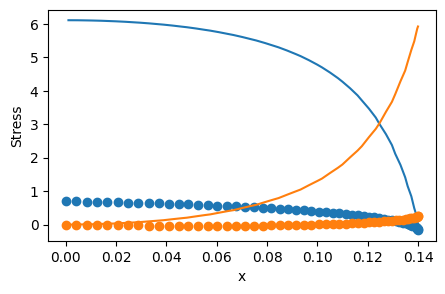

iteration: 36, Weight_NEU: -4.553358912990311e-07, Weight_PDE: -1.6504691551707454e-07, Stress Error: 25.800281976209757, , lr: 9.999964000063019e-08


100%|█████████▉| 3999/4000 [33:37<00:00,  2.18it/s]

ADAM Weight_NEU: 4.553358912990311e-07, ADAM Weight_PDE: 1.6504691551707454e-07


100%|██████████| 4000/4000 [33:37<00:00,  1.98it/s]


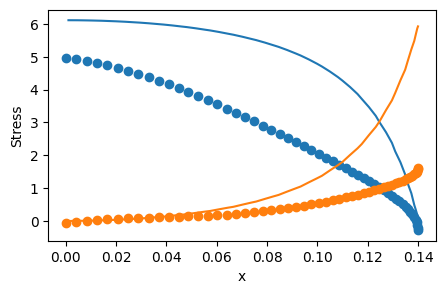

iteration: 37, Weight_NEU: -4.7293938437753104e-07, Weight_PDE: -1.6783086843013044e-07, Stress Error: 9.4894416174301, , lr: 9.99996300006662e-08


100%|█████████▉| 3999/4000 [32:44<00:00,  1.90it/s]

ADAM Weight_NEU: 4.7293938437753104e-07, ADAM Weight_PDE: 1.6783086843013044e-07


100%|██████████| 4000/4000 [32:45<00:00,  2.04it/s]


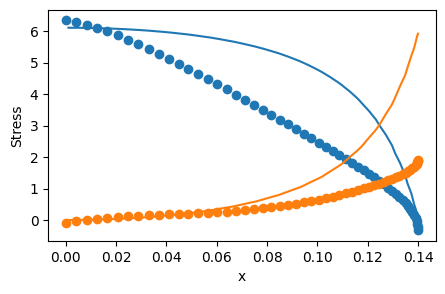

iteration: 38, Weight_NEU: -4.882761670846996e-07, Weight_PDE: -1.6023627168445274e-07, Stress Error: 7.284399854297547, , lr: 9.99996200007032e-08


100%|█████████▉| 3999/4000 [32:13<00:00,  2.20it/s]

ADAM Weight_NEU: 4.882761670846996e-07, ADAM Weight_PDE: 1.6023627168445274e-07


100%|██████████| 4000/4000 [32:14<00:00,  2.07it/s]


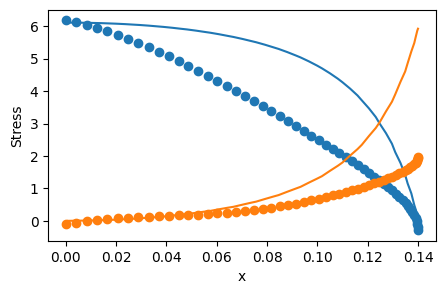

iteration: 39, Weight_NEU: -5.015259051253132e-07, Weight_PDE: -1.4544159799464838e-07, Stress Error: 7.188507367428127, , lr: 9.99996100007412e-08


100%|█████████▉| 3999/4000 [32:22<00:00,  2.22it/s]

ADAM Weight_NEU: 5.015259051253132e-07, ADAM Weight_PDE: 1.4544159799464838e-07


100%|██████████| 4000/4000 [32:23<00:00,  2.06it/s]


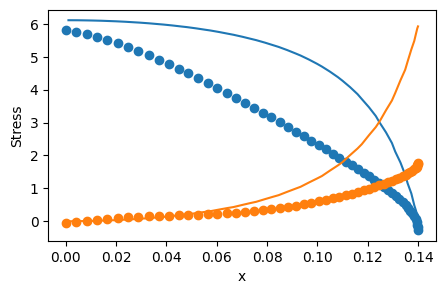

iteration: 40, Weight_NEU: -5.131763164841842e-07, Weight_PDE: -1.2488206116894218e-07, Stress Error: 7.980126937072416, , lr: 9.999960000078021e-08


100%|█████████▉| 3999/4000 [33:25<00:00,  1.81it/s]

ADAM Weight_NEU: 5.131763164841842e-07, ADAM Weight_PDE: 1.2488206116894218e-07


100%|██████████| 4000/4000 [33:26<00:00,  1.99it/s]


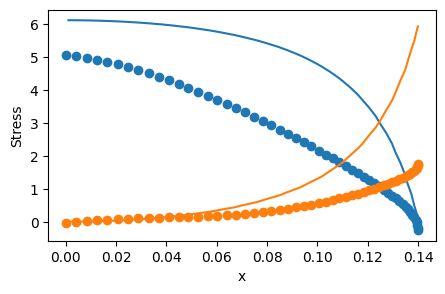

iteration: 41, Weight_NEU: -5.233137703968033e-07, Weight_PDE: -9.82341445776256e-08, Stress Error: 8.902886451153249, , lr: 9.999959000082021e-08


100%|█████████▉| 3999/4000 [32:44<00:00,  2.20it/s]

ADAM Weight_NEU: 5.233137703968033e-07, ADAM Weight_PDE: 9.82341445776256e-08


100%|██████████| 4000/4000 [32:44<00:00,  2.04it/s]


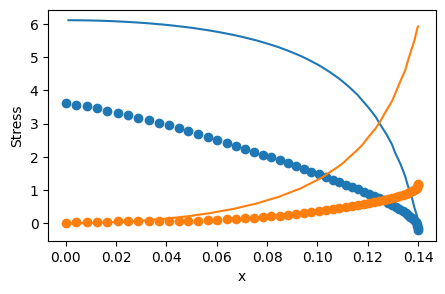

iteration: 42, Weight_NEU: -5.291218968522369e-07, Weight_PDE: -5.031224271076276e-08, Stress Error: 13.599279406258033, , lr: 9.999958000086121e-08


100%|█████████▉| 3999/4000 [33:43<00:00,  1.82it/s]

ADAM Weight_NEU: 5.291218968522369e-07, ADAM Weight_PDE: 5.031224271076276e-08


100%|██████████| 4000/4000 [33:43<00:00,  1.98it/s]


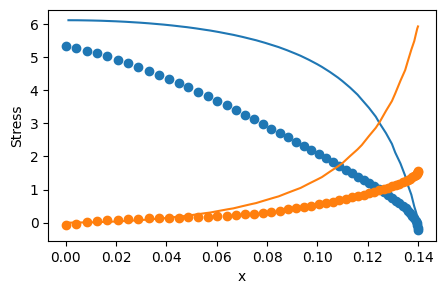

iteration: 43, Weight_NEU: -5.337360503295829e-07, Weight_PDE: 1.3718938903810802e-08, Stress Error: 9.236830134370864, , lr: 9.999957000090323e-08


100%|█████████▉| 3999/4000 [30:12<00:00,  2.23it/s]

ADAM Weight_NEU: 5.337360503295829e-07, ADAM Weight_PDE: 1.3718938903810802e-08


100%|██████████| 4000/4000 [30:12<00:00,  2.21it/s]


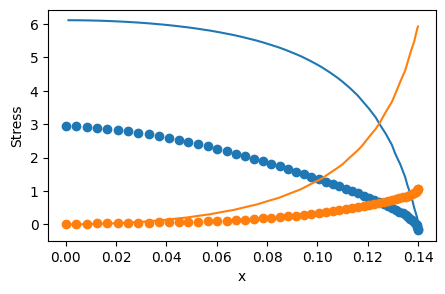

iteration: 44, Weight_NEU: -5.375650225262284e-07, Weight_PDE: 1.0970751690149364e-08, Stress Error: 15.007271580906437, , lr: 9.999956000094623e-08


100%|█████████▉| 3999/4000 [33:09<00:00,  1.81it/s]

ADAM Weight_NEU: 5.375650225262284e-07, ADAM Weight_PDE: 1.0970751690149364e-08


100%|██████████| 4000/4000 [33:10<00:00,  2.01it/s]


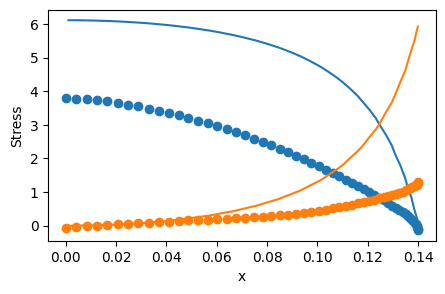

iteration: 45, Weight_NEU: -5.408403506507674e-07, Weight_PDE: -1.5569567355682817e-08, Stress Error: 11.898774984310956, , lr: 9.999955000099024e-08


100%|█████████▉| 3999/4000 [33:19<00:00,  1.82it/s]

ADAM Weight_NEU: 5.408403506507674e-07, ADAM Weight_PDE: 1.5569567355682817e-08


100%|██████████| 4000/4000 [33:20<00:00,  2.00it/s]


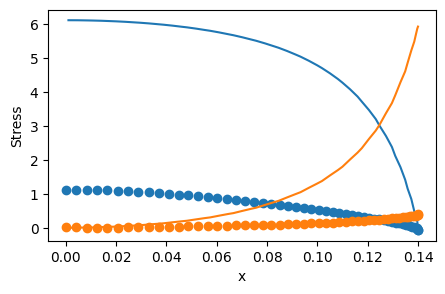

iteration: 46, Weight_NEU: -5.430843547077738e-07, Weight_PDE: 1.6602836505308232e-08, Stress Error: 23.596628641542985, , lr: 9.999954000103524e-08


100%|█████████▉| 3999/4000 [33:58<00:00,  1.81it/s]

ADAM Weight_NEU: 5.430843547077738e-07, ADAM Weight_PDE: 1.6602836505308232e-08


100%|██████████| 4000/4000 [33:59<00:00,  1.96it/s]


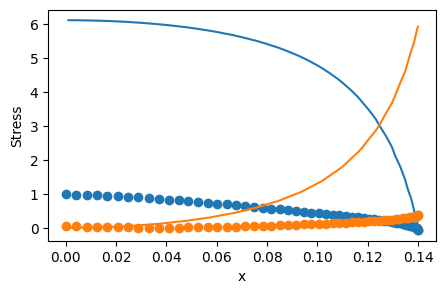

iteration: 47, Weight_NEU: -5.44706290277299e-07, Weight_PDE: 1.5859201990481753e-08, Stress Error: 24.497753026498607, , lr: 9.999953000108125e-08


100%|█████████▉| 3999/4000 [33:15<00:00,  2.22it/s]

ADAM Weight_NEU: 5.44706290277299e-07, ADAM Weight_PDE: 1.5859201990481753e-08


100%|██████████| 4000/4000 [33:15<00:00,  2.00it/s]


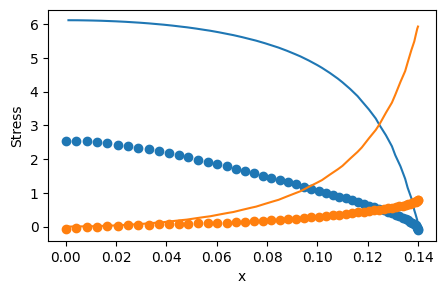

iteration: 48, Weight_NEU: -5.457983000249884e-07, Weight_PDE: -1.4676828893297375e-08, Stress Error: 17.303227557695102, , lr: 9.999952000112825e-08


100%|█████████▉| 3999/4000 [33:25<00:00,  1.81it/s]

ADAM Weight_NEU: 5.457983000249884e-07, ADAM Weight_PDE: 1.4676828893297375e-08


100%|██████████| 4000/4000 [33:26<00:00,  1.99it/s]


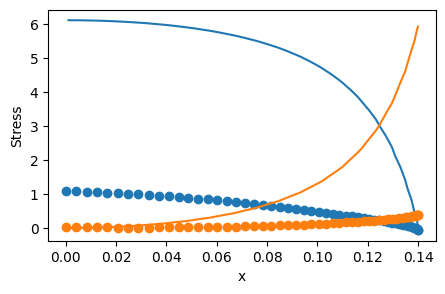

iteration: 49, Weight_NEU: -5.457164941264331e-07, Weight_PDE: 3.0101162430203426e-08, Stress Error: 23.95552802397733, , lr: 9.999951000117626e-08


100%|█████████▉| 3999/4000 [34:15<00:00,  2.21it/s]

ADAM Weight_NEU: 5.457164941264331e-07, ADAM Weight_PDE: 3.0101162430203426e-08


100%|██████████| 4000/4000 [34:16<00:00,  1.95it/s]


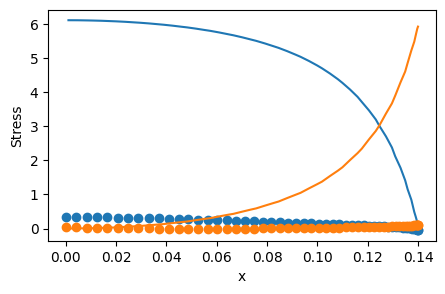

iteration: 50, Weight_NEU: -5.439173960890811e-07, Weight_PDE: 6.021805836609343e-08, Stress Error: 28.203442364307204, , lr: 9.999950000122525e-08


In [80]:
# Epochs
epochs_adam = 4000 #2.5-3it/s -> 7min #previous value -> 5600
epochs_lbfgs = 0 
# Batch size
batch_size = 64
# Learning rate
lr = 0.005 #previous value -> 0.005
weight_lr = 1.0e-07 #previous value -> 0.00001
# Scheduler step width
scheduler_step = 300
# Gamma factor of scheduler
scheduler_gamma = 0.7 # #previous value -> 0.6-0.8 or 0.55
exponential_gamma = 0.999 #previous value -> 0.9994162117


loss_history = []
weight_history = []
testruns = 30 #total amount of test runs
test = 1 #have to be 1
# Weight_PDE = 8.0e-06 #previous value -> 0.00005
# Weight_NEU = 7.999999999999999e-05 #previous value -> 0.0001
stressError = torch.tensor(19) #previous value 
#describes new weight = weight*factor for each step
#if(Error > previous Error ) -> factor = 1/factor
factor = 5
token = 0 #changes weight_case if token will be changed twice
weight_case = 1 #0->PDE; 1->NEU; 2->PDE and NEU; 3->no weight changes

data_hole = np.loadtxt(f"data/hole_Rx={Rx}.csv", delimiter=",")
data_hole = data_hole[data_hole[:, 0].argsort()]
data_stress_x = data_hole[:, 2]
data_stress_y = data_hole[:, 3]




#interpolate data_stress_x and data_stress_y
f_stress_x = interp1d(data_hole[:, 0], data_hole[:, 2], kind='cubic')
f_stress_y = interp1d(data_hole[:, 0], data_hole[:, 3], kind='cubic')
x_new = np.linspace(data_hole[:, 0][-1], data_hole[:, 0][0], hole[:, 0].size(dim=0))
y_stress_x = f_stress_x(x_new)
y_stress_y = f_stress_y(x_new)


#previous Weight_NEU und Weight_PDE als PyTorch nn parameter 
# Weight_NEU = torch.nn.Parameter(torch.tensor(1.6e-05), requires_grad=True)
# Weight_PDE = torch.nn.Parameter(torch.tensor(8.0e-06), requires_grad=True)
#iteration: 26, Weight_NEU: 1.8841683879627231e-06, Weight_PDE: 3.1355081392423563e-06, Stress Error: 6.01981784519743, , lr: 7.700431458051553e-08

#Weight_NEU und Weight_PDE als PyTorch nn parameter 
Weight_NEU = torch.nn.Parameter(torch.tensor(1.8841683879627231e-06), requires_grad=True) #previous value -> 6.4531255763296895e-06
Weight_PDE = torch.nn.Parameter(torch.tensor(3.1355081392423563e-06), requires_grad=True) #previous value -> 8.376708219353885e-06


def train_weights(W_neu, W_pde):
    
    #optimizer with parameter of nn and weights for optimization
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    #scheduler = StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)
    scheduler = ExponentialLR(optimizer, gamma=exponential_gamma)
    for epoch in tqdm(range(epochs_adam)):
        # Permutation to shuffle collocation points randomly in each epoch
        permutation = torch.randperm(collocation.size()[0])
        if(epoch >= epochs_adam-1):
            print(f"ADAM Weight_NEU: {torch.abs(W_neu).item()}, ADAM Weight_PDE: {torch.abs(W_pde).item()}")

        for i in range(0, collocation.size()[0], batch_size):
            indices = permutation[i : i + batch_size]
            collo = collocation[indices]
            optimizer.zero_grad()

            # Compute physics losses
            left_l, right_l, bottom_l, top_l, hole_l, pde_l = compute_physics_losses(collo)

            # Aggregate losses
            dirichlet_losses = left_l + bottom_l 
            neumann_losses = right_l + top_l + hole_l

            loss = (
                dirichlet_losses
                + torch.abs(W_neu) * neumann_losses
                + torch.abs(W_pde) * pde_l
            )

            # Make optimization step after batch
            loss.backward(retain_graph=True)
            optimizer.step()

        # Make scheduler step after full epoch
        scheduler.step()

    # append loss to history (important for plotting)
    with torch.autograd.no_grad():
        loss_history.append(float(loss.data))

    # compare computed stressError(PINN) with actual stressError
    stress_hole = torch.vmap(sigma)(hole)
    stressError = mse(stress_hole[:, 0, 0], torch.tensor(y_stress_x)) + mse(stress_hole[:, 1, 1], torch.tensor(y_stress_y))
    return stressError



weights_optimizer = torch.optim.Adam([Weight_NEU, Weight_PDE], lr=weight_lr)
weights_scheduler = ExponentialLR(weights_optimizer, gamma=0.9999999)
for i in range(50):
    weights_optimizer.zero_grad()
    mse_error = train_weights(Weight_NEU, Weight_PDE)
    mse_error.backward()
    weights_optimizer.step()
    weights_scheduler.step()

    with torch.autograd.no_grad():
        weight_history.append(float(mse_error.data))
        stress_hole = torch.vmap(sigma)(hole)
        plt.figure(figsize=(5, 3))
        plt.plot(hole[:, 0], stress_hole[:, 0, 0], "o", color="tab:blue", label="σ_xx (PINN)")
        plt.plot(data_hole[:, 0], data_hole[:, 2], "-", color="tab:blue", label="σ_xx (FEM)")
        plt.plot(hole[:, 0], stress_hole[:, 1, 1], "o", color="tab:orange", label="σ_yy (PINN)")
        plt.plot(data_hole[:, 0], data_hole[:, 3], "-", color="tab:orange", label="σ_yy (FEM)")
        plt.xlabel("x")
        plt.ylabel("Stress")
        #plt.legend()
        plt.show()
        
    # print weights and stress error 
    print(f"iteration: {i+1}, Weight_NEU: {Weight_NEU.item()}, Weight_PDE: {Weight_PDE.item()}, Stress Error: {mse_error.item()}, , lr: {weights_optimizer.param_groups[0]['lr']}")




## Visualization of results

the final x_stress Error is 19


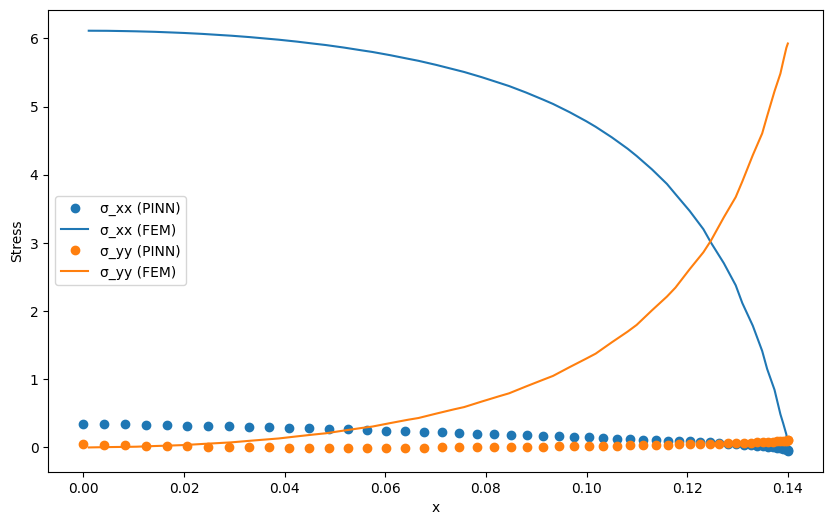

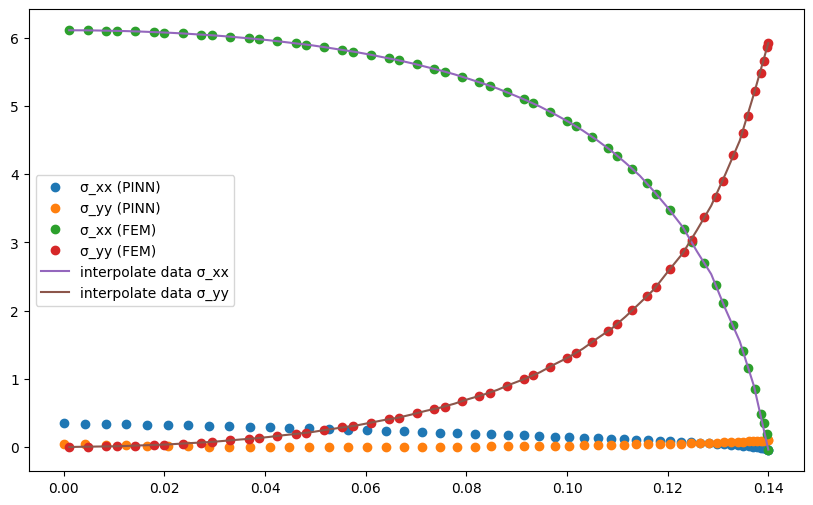

In [81]:
from scipy.interpolate import interp1d


stress_hole = torch.vmap(sigma)(hole)
data_hole = np.loadtxt(f"data/hole_Rx={Rx}.csv", delimiter=",")
data_hole = data_hole[data_hole[:, 0].argsort()]

#stressError = mse(stress_hole[:, 1, 1], torch.tensor(y_stress_y)) + mse(stress_hole[:, 0, 0], torch.tensor(y_stress_x)) 
print("the final x_stress Error is", stressError.item())

with torch.no_grad():
    plt.figure(figsize=(10, 6))
    plt.plot(hole[:, 0], stress_hole[:, 0, 0], "o", color="tab:blue", label="σ_xx (PINN)")
    plt.plot(data_hole[:, 0], data_hole[:, 2], "-", color="tab:blue", label="σ_xx (FEM)")
    plt.plot(hole[:, 0], stress_hole[:, 1, 1], "o", color="tab:orange", label="σ_yy (PINN)")
    plt.plot(data_hole[:, 0], data_hole[:, 3], "-", color="tab:orange", label="σ_yy (FEM)")
    plt.xlabel("x")
    plt.ylabel("Stress")
    plt.legend()
    plt.show()

f_stress_x = interp1d(data_hole[:, 0], data_hole[:, 2], kind='cubic')
f_stress_y = interp1d(data_hole[:, 0], data_hole[:, 3], kind='cubic')
x_new = np.linspace(data_hole[:, 0][0], data_hole[:, 0][-1], 50)
#x_new = np.linspace(data_hole[:, 0][-1], data_hole[:, 0][0], hole[:, 0].size(dim=0))
y_stress_x = f_stress_x(x_new)
y_stress_y = f_stress_y(x_new)



# plt.plot(data_hole[:, 0], data_hole[:, 2],'o', x_new, y_stress_x)
# plt.plot(data_hole[:, 0], data_hole[:, 3],'o', x_new, y_stress_y)
# plt.xlim([data_hole[:, 0][0]-1, data_hole[:, 0][-1] + 1 ])
# plt.show()

# Erstellen Sie das Plot
with torch.no_grad():
    plt.figure(figsize=(10, 6))
    plt.plot(hole[:, 0], stress_hole[:, 0, 0], 'o', label='σ_xx (PINN)')
    plt.plot(hole[:, 0], stress_hole[:, 1, 1], 'o', label='σ_yy (PINN)')
    plt.plot(data_hole[:, 0], data_hole[:, 2], 'o', label='σ_xx (FEM)')
    plt.plot(data_hole[:, 0], data_hole[:, 3], 'o', label='σ_yy (FEM)')
    plt.plot(x_new, y_stress_x, '-', label='interpolate data σ_xx')
    plt.plot(x_new, y_stress_y, '-', label='interpolate data σ_yy')
    plt.legend()
    plt.show()


In [82]:
# Create a validation domain different from the training domain
val_x, val_y = np.meshgrid(np.linspace(0, L, 50), np.linspace(0, L, 50))
val_domain = np.vstack([val_x.ravel(), val_y.ravel()]).T
mask = (
    ((val_domain[:, 0] ** 2) / (Rx**2)) + ((val_domain[:, 1] ** 2) / (Ry**2))
) > 1
val = torch.tensor(val_domain[mask], requires_grad=True).double()

# Compute model predictions on the validation domain
disp = net(val)
def_val = val + disp
stress = torch.vmap(sigma)(val)
mises = torch.sqrt(
    stress[:, 0, 0] ** 2
    + stress[:, 1, 1] ** 2
    - stress[:, 0, 0] * stress[:, 1, 1]
    + 3 * stress[:, 0, 1] ** 2
)
# print([loss.item() for loss in compute_les(val)])


@torch.no_grad()
def make_plot(x, y, variable, title, cmap=sequential.Viridis, size=8.0):
    fig = go.Figure()

    # Plot boundaries
    m = dict(color="black")
    fig.add_trace(go.Scatter(x=top[:, 0], y=top[:, 1], mode="lines", marker=m))
    fig.add_trace(go.Scatter(x=bottom[:, 0], y=bottom[:, 1], mode="lines", marker=m))
    fig.add_trace(go.Scatter(x=left[:, 0], y=left[:, 1], mode="lines", marker=m))
    fig.add_trace(go.Scatter(x=right[:, 0], y=right[:, 1], mode="lines", marker=m))
    fig.add_trace(go.Scatter(x=hole[:, 0], y=hole[:, 1], mode="lines", marker=m))

    # Plot variable values
    m = dict(color=variable, colorscale=cmap, size=size, colorbar=dict(thickness=10))
    fig.add_trace(go.Scatter(x=x, y=y, marker=m, mode="markers"))

    # plot settings
    fig.layout.yaxis.scaleanchor = "x"
    fig.update_layout(
        template="none", width=400, height=400, title=title, showlegend=False
    )
    fig.update_xaxes(visible=False)
    fig.update_yaxes(visible=False)
    fig.show()


# Compute data error
s_data = data_output[:, 0:3]
s_pred = torch.vmap(sigma)(data_input[:, 0:2])
ds_xx = s_data[:, 0] - s_pred[:, 0, 0]
ds_yy = s_data[:, 1] - s_pred[:, 1, 1]
ds_xy = s_data[:, 2] - s_pred[:, 0, 1]


# Plot stress errors
cmap = sequential.RdBu_r
make_plot(*data_input[:, 0:2].T, ds_xx, "Stress error xx", size=2.0, cmap=cmap)
make_plot(*data_input[:, 0:2].T, ds_yy, "Stress error yy", size=2.0, cmap=cmap)
make_plot(*data_input[:, 0:2].T, ds_xy, "Stress error xy", size=2.0, cmap=cmap)

# Plot stresses
make_plot(*def_val.T, stress[:, 0, 0], "Stress xx")
make_plot(*def_val.T, stress[:, 0, 1], "Stress xy")
make_plot(*def_val.T, stress[:, 1, 1], "Stress yy")
make_plot(*def_val.T, mises, "Mises stress")

# Plot displacements
make_plot(*def_val.T, disp[:, 0], "Displacement in x", cmap=sequential.Inferno)
make_plot(*def_val.T, disp[:, 1], "Displacement in y", cmap=sequential.Inferno)


In [83]:
#zwischenablage

            # if W_DISP < 1E-10 and W_STRESS < 1E-10:
            #     # No data losses needed (we can accelerate training by skipping this part)
            #     stress_l = 0.0
            #     disp_l = 0.0
            # else:
            #     # Get samples from reference solution
            #     samples = torch.randperm(data_output.size()[0])[::100]
            #     # Reference solutions
            #     s_data = data_output[samples, 0:3]
            #     e_data = data_output[samples, 4:7]
            #     u_data = data_output[samples, 7:10]
            #     # Predictions
            #     s_pred = torch.vmap(sigma)(data_input[samples, 0:2])
            #     e_pred = torch.vmap(epsilon)(data_input[samples, 0:2])
            #     u_pred = net(data_input[samples, 0:2])
            #     # Compute data losses
            #     ds_xx = mse(s_data[:, 0], s_pred[:, 0, 0])
            #     ds_yy = mse(s_data[:, 1], s_pred[:, 1, 1])
            #     ds_xy = mse(s_data[:, 2], s_pred[:, 0, 1])
            #     stress_l = ds_xx + ds_yy + ds_xy
            #     du_x = mse(u_data[:, 0], u_pred[:, 0])
            #     du_y = mse(u_data[:, 1], u_pred[:, 1])
            #     disp_l = du_x + du_y